In [3]:
# Montar Google Drive para acceder al dataset
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MNA/Colab Notebooks/MNA/Navegacion autonoma/Actividad 4.1 - Deteccion de Peatones con Keras/Train pics'



ModuleNotFoundError: No module named 'google'

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2025-06-09 01:22:24.440912: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 01:22:24.669336: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 01:22:24.804199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749432145.110992   31178 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749432145.205830   31178 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749432145.855402   31178 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Num GPUs Available: 0


2025-06-09 01:22:31.832991: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [1]:
data_dir='INRIA_Person/'

In [2]:
# Importar librerías usadas en la aplicación
# !pip install keras

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import keras #Para construir redes neuronales
from keras.models import Sequential #Modelo secuencial
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #Dense para capas conectadas y Flatten para aplanar la entrada
from keras.optimizers import Adam #Optimizador Adam
import keras_metrics
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Cargar y procesar imagenes desde carpetas.
                                                                    #Se utiliza Tensorflow porque en versiones modernas de Keras, ImageDataGenerator
                                                                    #ya no se importa desde Keras, se debe importar ahora desde tensorflow.keras

2025-06-08 23:57:14.828960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 23:57:17.023499: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 23:57:17.295049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749427039.883212    2176 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749427041.311444    2176 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749427050.960822    2176 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# # Normalización y división de entrenamiento/validación
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# # Crear generador para entrenamiento
# train_gen = datagen.flow_from_directory(
#     data_dir,               #Dirección a las imágenes
#     target_size=(64, 128),  # Tamaño al que se redimensionan las imágenes
#     batch_size=32,          # Agrupa las imagenes en paquetes de 32 para ser procesadas en paquetes
#     class_mode='binary',  # Salida binaria
#     subset='training'  # Usa el 80% para entrenamiento
# )

# # Crear generador para validación
# val_gen = datagen.flow_from_directory(
#     data_dir,
#     target_size=(64, 128),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'  # Usa el 20% para validación
# )


# Data augmentation + normalización para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza los pixeles a [0,1]
    validation_split=0.2,    # Divide el dataset en entrenamiento y validación
    rotation_range=10,       # Rota imágenes hasta 10 grados para variedad
    width_shift_range=0.1,   # Desplaza horizontalmente hasta 10%
    height_shift_range=0.1,  # Desplaza verticalmente hasta 10%
    zoom_range=0.1,          # Zoom aleatorio hasta 10%
    horizontal_flip=True     # Voltea horizontalmente (solo si aplica a tu problema)
)

# Solo normalización para validación (sin augmentations)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generador para entrenamiento usando augmentations
train_gen = train_datagen.flow_from_directory(
    data_dir,               # Carpeta con imágenes organizadas en subcarpetas por clase
    target_size=(64, 128),  # Redimensiona imágenes a 64x128 (ancho x alto)
    batch_size=32,          # Procesa en lotes de 32 imágenes
    class_mode='binary',    # Clasificación binaria
    subset='training'       # Usa el 80% para entrenamiento
)

# Generador para validación sin augmentations
val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'     # Usa el 20% para validación
)

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.


In [4]:
print(f"Imágenes en entrenamiento: {train_gen.samples}")
print(f"Imágenes en validación: {val_gen.samples}")
print(f"Clases: {train_gen.class_indices}")

Imágenes en entrenamiento: 1467
Imágenes en validación: 365
Clases: {'neg': 0, 'pos': 1}


In [5]:
# Crear modelo secuencial CNN
model = Sequential()
# # Aplanar la imagen de entrada (64x128x3 - vector)
# model.add(Flatten(input_shape=(128, 64, 3)))  # alto=128, ancho=64, canales=3 - 24,576 entradas

#Primera capa convolucional
model.add(Conv2D(256, (3, 3), activation='linear', input_shape=(128, 64, 3)))  # Filtros 3x3
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce tamaño espacial a la mitad

#Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar para conectar con capas densas
model.add(Flatten())

# Capa oculta totalmente conectada con Dropout para regularización
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid')) # Capa de salida: clasificación binaria

# Callbacks: parada temprana y reducción del LR si no mejora
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1)

# Compilar el modelo
#model.compile(optimizer=Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['recall'])
#model.compile(optimizer="adamax", loss='binary_crossentropy', metrics=['precision'])
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.Recall(thresholds=0),'precision'])


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-08 23:58:08.670284: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
#Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 62, 256)   │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 29, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,752,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981,569 (11.37 MB)

 Trainable params: 2,981,569 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entrenar el modelo
hist = model.fit(train_gen, validation_data=val_gen, verbose = 2, epochs=50, callbacks=[early_stop, reduce_lr], shuffle = 'true')


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-06-08 23:58:35.335483: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255983616 exceeds 10% of free system memory.
2025-06-08 23:58:38.909575: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 63995904 exceeds 10% of free system memory.
2025-06-08 23:58:40.076855: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20127744 exceeds 10% of free system memory.
2025-06-08 23:58:40.560373: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32606208 exceeds 10% of free system memory.
2025-06-08 23:58:40.562296: W external/local_xla/xla/tsl/framework/cpu_allocator_

46/46 - 142s - 3s/step - loss: 1.0733 - precision: 0.3023 - recall: 1.0000 - val_loss: 0.6312 - val_precision: 0.0000e+00 - val_recall: 1.0000 - learning_rate: 1.0000e-03
Epoch 2/50
46/46 - 77s - 2s/step - loss: 0.6278 - precision: 0.0000e+00 - recall: 1.0000 - val_loss: 0.5950 - val_precision: 0.0000e+00 - val_recall: 1.0000 - learning_rate: 1.0000e-03
Epoch 3/50
46/46 - 70s - 2s/step - loss: 0.5730 - precision: 0.5992 - recall: 1.0000 - val_loss: 0.4434 - val_precision: 0.9074 - val_recall: 1.0000 - learning_rate: 1.0000e-03
Epoch 4/50
46/46 - 75s - 2s/step - loss: 0.5257 - precision: 0.6273 - recall: 1.0000 - val_loss: 0.4159 - val_precision: 0.8857 - val_recall: 1.0000 - learning_rate: 1.0000e-03
Epoch 5/50
46/46 - 69s - 2s/step - loss: 0.5066 - precision: 0.6298 - recall: 1.0000 - val_loss: 0.4035 - val_precision: 0.9231 - val_recall: 1.0000 - learning_rate: 1.0000e-03
Epoch 6/50
46/46 - 69s - 1s/step - loss: 0.4900 - precision: 0.6565 - recall: 1.0000 - val_loss: 0.3748 - val_pre

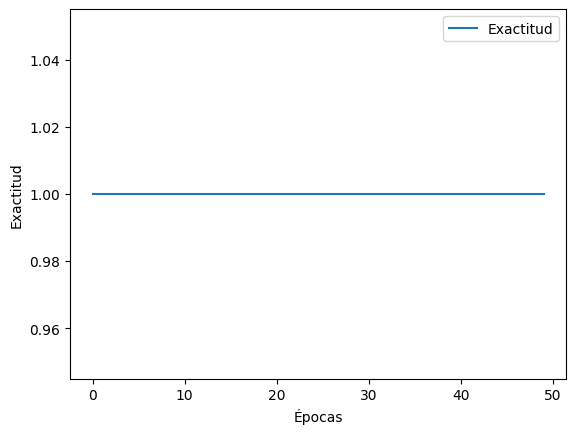

In [ ]:
#Graficar error y exactitud del modelo
plt.plot(hist.history['recall'])
plt.legend(['Exactitud'])
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.show()

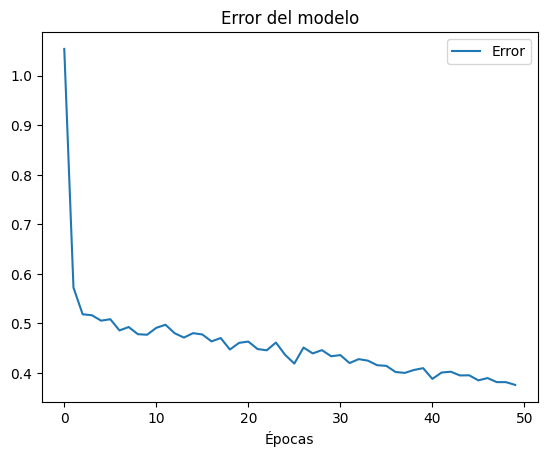

In [32]:
plt.plot(hist.history['loss'])
plt.legend(['Error'])
plt.title('Error del modelo')
plt.xlabel('Épocas')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


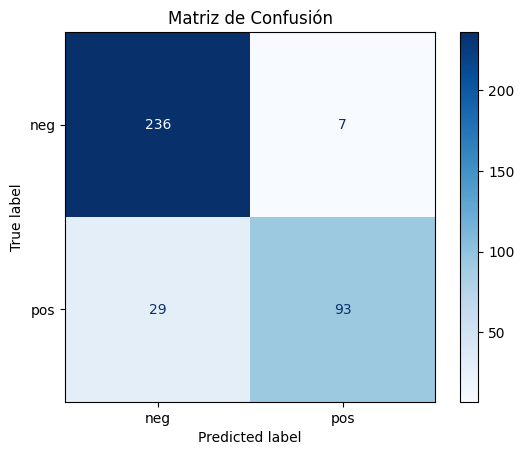

In [33]:
# Listas para almacenar todas las imágenes y etiquetas
X_test = []
y_test = []

# Calculamos cuántos batchs hay en total en val_gen
num_batches = int(np.ceil(val_gen.samples / val_gen.batch_size))

# Recorremos todos los lotes del generador de validación
for _ in range(num_batches):
    x_batch, y_batch = next(val_gen) # Obtenemos un lote de imágenes y etiquetas
    X_test.extend(x_batch)          # Agregamos las imágenes a la lista
    y_test.extend(y_batch)

# Convertimos las listas a arreglos
X_test = np.array(X_test)
y_test = np.array(y_test)

# Predecir las clases
y_predict = (model.predict(X_test) > 0.5).astype(int).flatten()

# Evaluar en conjunto de prueba
#loss, acc = model.evaluate(X_test, y_test)
#print(f"Precisión en test: {acc:.4f}, Pérdida: {loss:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()
